In [1232]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1233]:
from sklearn.metrics import mean_squared_error

cheat = pd.read_csv("./result-with-best.csv")

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cheat_score(model):
    print("RMSLE sub: " + str(rmsle(model.predict(validation), np.log1p(cheat["SalePrice"]))))

In [1234]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

In [1235]:
data = remove_outliers(data)

In [1236]:
y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

print(X.shape)
X.head()

(1454, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [1237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

In [1238]:
X_train_orig = X_train.copy()

transformer = DataTransformer(StandardScaler())

X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

(1163, 23) (1163, 338)
(291, 23) (291, 338)


In [1290]:
print(X_train.isnull().sum().sum())
X_train.head()

0


,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,328,329,330,331,332,333,334,335,336,337
0,-0.736211,-1.489457,-0.565665,-1.012857,-0.285104,0.715367,-0.406139,-0.692505,-0.798547,-0.122363,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.399284,0.996677,-0.565665,0.517566,-0.285104,-0.657973,-0.261436,-0.584126,1.259460,-0.122363,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.028030,-0.229816,0.398496,-0.562462,1.986686,0.921595,1.118067,0.965706,-0.798547,-0.122363,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.098791,-1.489457,-0.565665,0.062576,-0.285104,-0.494804,-0.565313,-0.925522,0.133987,-0.122363,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.352053,-0.561300,-0.565665,-1.012857,-0.285104,0.844543,-0.268671,-0.440522,0.287879,-0.122363,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1240]:
#cheat sheet
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)

validation = transformer.transform(validation)

(1459, 23) (1459, 338)


In [1241]:
def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

## Гоняем котов

In [1242]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]

In [1243]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

cat_model = CatBoostRegressor(iterations=10000, task_type="GPU",  devices='0:1')
cat_model.fit(train_pool, eval_set=dev_pool, early_stopping_rounds=10, verbose=0, plot=False)

In [1244]:
evaluate(cat_model, X_train, y_train)
evaluate(cat_model, X_test, y_test)


RMSLE: 0.10128085928283345
RMSLE: 0.1271962737052869


## Конвертим данные под lgb

In [1245]:
def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')


In [1246]:
#to_categorical(X_train)
#to_categorical(X_test)

In [1247]:
import lightgbm as lgb

clf = lgb.LGBMRegressor(objective='regression',
                        num_leaves=4,
                        learning_rate=0.01,
                        n_estimators=5000,
                        max_bin=200,
                        bagging_fraction=0.75,
                        bagging_freq=5,
                        bagging_seed=7,
                        feature_fraction=0.2,
                        feature_fraction_seed=7,
                        verbose=-1,)

fit_params = {"early_stopping_rounds": 20,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1,
              #'categorical_feature': cat_features
              }
clf.fit(X_train, y_train, **fit_params)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, learning_rate=0.01,
              max_bin=200, n_estimators=5000, num_leaves=4,
              objective='regression', verbose=-1)

In [1248]:
evaluate(clf, X_train, y_train)
evaluate(clf, X_test, y_test)

RMSLE: 0.10385330659157134
RMSLE: 0.12311932876755952


In [1249]:
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

folds = 4
shuffle = True

random_state = 42

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves'])}

    clf = lgb.LGBMRegressor(random_state=random_state, **params)

    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)

        prediction = clf_fold.predict(X_test_fold)
        loss = rmsle(prediction, y_test_fold)
        loss_list.append(loss)

    score = np.mean(loss_list)

    #print("{:.3f} params {}".format(score, params))
    return score

In [1250]:
space={'n_estimators': hp.quniform('n_estimators', 100, 10000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
       'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
       }
trials = Trials()

best=fmin(fn=objective, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate = np.random.default_rng(random_state) # fixing random state for the reproducibility
          )

print("best {}".format(best))

100%|██████████| 100/100 [00:57<00:00,  1.75trial/s, best loss: 0.13118749655016557]
best {'learning_rate': 0.09061857284329498, 'max_depth': 17.0, 'n_estimators': 5709.0, 'num_leaves': 13.0}


In [1251]:
lbg_model = lgb.LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']), learning_rate=best['learning_rate'], num_leaves = int(best['num_leaves']))
lbg_model.fit(X_train, y_train, **fit_params)

evaluate(lbg_model, X_train, y_train)
evaluate(lbg_model, X_test, y_test)

RMSLE: 0.06691436984635571
RMSLE: 0.12865131838597968


In [1252]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=1.,
    eta=0.01,
    max_depth=4,
    min_child_weight=1.5,
    n_estimators=14400,
    alpha=0.,
    reg_lambda=0.4,
    subsample=0.2)

xgb_model.fit(X_train, y_train, verbose=False)

evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)

RMSLE: 0.004808074919440381
RMSLE: 0.11357736106398501


In [1253]:
def predict_blend(X):
    return 0.1 * lbg_model.predict(X) + 0.1 * cat_model.predict(X) + 0.8 * xgb_model.predict(X)

predictions = predict_blend(X_train)
print("RMSLE: " + str(rmsle(predictions, y_train)))

predictions = predict_blend(X_test)
print("RMSLE: " + str(rmsle(predictions, y_test)))

print("RMSLE sub: " + str(rmsle(predict_blend(validation), np.log1p(cheat["SalePrice"]))))

RMSLE: 0.01833114014093808
RMSLE: 0.11179564115888274
RMSLE sub: 0.13576510605339312


### где мы косячим

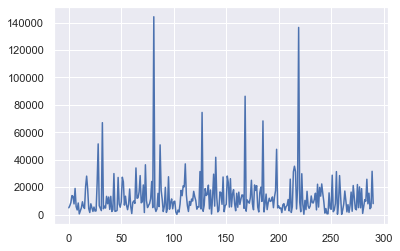

In [1254]:
differences = np.abs((np.expm1(predict_blend(X_test)) - np.expm1(y_test)))

outliers_ids = np.where(differences > 60000)[0]
plt.plot(differences.values)

In [1255]:
num_candidates = list(X.dtypes[X.dtypes != "object"].index.values)

outliers_data = X_train_orig.iloc[outliers_ids][num_candidates]
df = pd.DataFrame(data=X_train_orig[num_candidates].mean())
#df.T.head()
df.T
#sns.displot(outliers_data['LotFrontage'])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,57.080825,70.390852,10162.478934,6.090284,5.552021,1970.932932,1984.466896,105.968939,440.768702,43.296647,...,471.858126,90.650903,46.764402,22.815993,3.251935,14.585555,3.050731,46.624248,6.329321,2007.818573


In [1256]:
outliers_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
783,85,NaN,9101,5,6,1978,1978,104.0,1097,0,...,602,303,30,0,0,0,0,0,7,2009
413,30,56.0,8960,5,6,1927,1950,0.0,0,0,...,360,0,0,130,0,0,0,0,3,2010
934,20,313.0,27650,7,7,1960,2007,0.0,425,0,...,505,0,0,0,0,0,0,0,11,2008
171,20,141.0,31770,6,5,1960,1960,112.0,639,0,...,528,210,62,0,0,0,0,0,5,2010
128,60,69.0,7590,6,5,1966,1966,266.0,512,0,...,453,188,108,0,0,0,0,0,7,2006
422,20,100.0,21750,5,5,1954,1954,0.0,0,0,...,520,0,0,0,0,0,0,0,2,2008


### Full dataset & submit

In [1299]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

#data = remove_outliers(data)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer(StandardScaler())
X = transformer.prepare(X)

transformer.fit(X)

X = transformer.transform(X)

(1460, 23) (1460, 342)


In [1300]:
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)

validation = transformer.transform(validation)

(1459, 23) (1459, 342)


In [1279]:
#to_categorical(X)
#to_categorical(validation)


In [1280]:
fit_params = {
              "eval_metric": 'rmse',
              'verbose': -1,
              #'categorical_feature': cat_features
              }
lbg_model = lgb.LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']), learning_rate=best['learning_rate'], num_leaves = int(best['num_leaves']))
lbg_model.fit(X, y, **fit_params)

predictions = lbg_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))

cheat_score(lbg_model)

RMSLE: 9.76679802624231e-05
RMSLE sub: 0.1349601751806444


In [1281]:
%%time

cat_features = np.where(X.loc[:, X.columns.values].dtypes == "object")[0]
train_pool = Pool(X, y, cat_features=cat_features)

cat_model = CatBoostRegressor(iterations=10000, task_type="GPU", devices='0:1')
cat_model.fit(train_pool, verbose=0, plot=False)

predictions = cat_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))

cheat_score(cat_model)

RMSLE: 0.06669332604267621
RMSLE sub: 0.13496761506078175
Wall time: 2min 1s


In [1282]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=1.,
    eta=0.01,
    max_depth=4,
    min_child_weight=1.5,
    n_estimators=14400,
    alpha=0.,
    reg_lambda=0.4,
    subsample=0.2)

xgb_model.fit(X, y, verbose=False)

predictions = xgb_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))
cheat_score(xgb_model)

RMSLE: 0.00792294912043575
RMSLE sub: 0.13603994105209535


In [1330]:
def predict_blend(X):
    return 0.1 * lbg_model.predict(X) + 0.1 * cat_model.predict(X) + 0.8 * xgb_model.predict(X)

In [1331]:
predictions = predict_blend(X)
print("RMSLE: " + str(rmsle(predictions, y)))

RMSLE: 0.011633915778626484


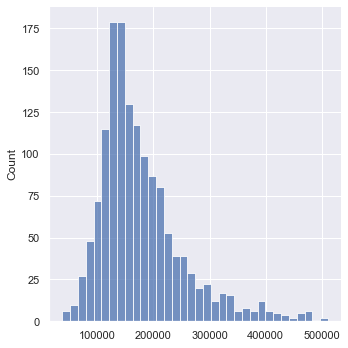

In [1332]:
submission = predict_blend(validation)
sns.displot( np.expm1(submission))

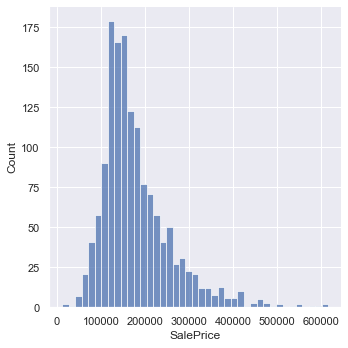

In [1333]:
sns.displot(cheat["SalePrice"])

In [1334]:
d = {'Id': val_ids.to_numpy(), 'SalePrice':  np.expm1(submission)}
df = pd.DataFrame(data=d)
df

,Id,SalePrice
0,1461,135123.684761
1,1462,165513.556057
2,1463,193636.760153
3,1464,196256.648382
4,1465,182042.473585
...,...,...
1454,2915,80384.217252
1455,2916,79210.040866
1456,2917,162778.084164
1457,2918,113112.571090


In [1335]:
df.to_csv('submission.csv', index=False)

RMSLE: 0.1333949585272273


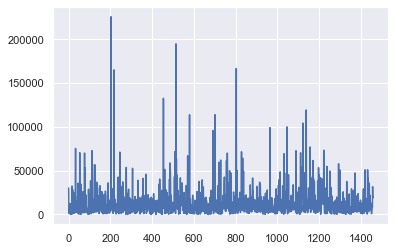

In [1336]:
print("RMSLE: " + str(rmsle(submission, np.log1p(cheat["SalePrice"]))))

plt.plot(np.abs(cheat["SalePrice"].to_numpy() - df["SalePrice"].to_numpy()))
plt.show()